# Sieci Bayesa w kontekście przewidywania toksyczności związków chemicznych (cz. 2)

## Karol Baran

W tym notatniku wykonano badania dotyczące modelu przewidującego wartość dwóch zmiennych celu (ang. multi-target) w zadaniu klasyfikacji z użyciem algorytmu sieci Bayesowskich (ang. Bayesian Belief Networks, BBN).

1. Import bibliotek

In [11]:
%%capture
#BAYES
!pip install bnlearn
#RDKIT
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

2. Import danych z pliku bazodanowego sdf

In [12]:
from rdkit.Chem import PandasTools
import pandas as pd
import os
from rdkit import RDConfig

sdfFile = os.path.join(RDConfig.RDDataDir,'/content/drive/MyDrive/bayes-konf-06-22/tox21.sdf') 
frame = PandasTools.LoadSDF(sdfFile, smilesName='SMILES', molColName='Molecule',
           includeFingerprints=True)
print(frame.columns)
print(frame.shape)

Index(['Formula', 'FW', 'DSSTox_CID', 'SR-HSE', 'ID', 'SMILES', 'Molecule',
       'NR-AR', 'SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP',
       'NR-ER', 'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD'],
      dtype='object')
(11761, 18)


3. Wyznaczenie deskryptorów

In [13]:
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import numpy as np

nBITS = 1024
fps = []
for index, row in frame.iterrows():
  fp = AllChem.GetMorganFingerprintAsBitVect(row['Molecule'],3,nBits=nBITS)
  arr = np.zeros((0,), dtype=np.int8)
  DataStructs.ConvertToNumpyArray(fp,arr)
  fps.append(arr)

4. Wstępne oczyszczenie danych

In [14]:
features_tox = ['NR-AR', 'NR-AR-LBD']
data = pd.concat([frame[features_tox], pd.DataFrame(fps)], axis=1)
data.dropna(subset=range(0,nBITS), how='any', inplace=True)
print(data.columns)
print(data.shape)

Index([    'NR-AR', 'NR-AR-LBD',           0,           1,           2,
                 3,           4,           5,           6,           7,
       ...
              1014,        1015,        1016,        1017,        1018,
              1019,        1020,        1021,        1022,        1023],
      dtype='object', length=1026)
(11761, 1026)


In [15]:
import bnlearn as bn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif

data_cur = data.dropna()

5. Wybór istotnych zmiennych z użyciem kryterium entropii

In [16]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.utils import resample

datas_down_cur = []
for i, _ in enumerate(features_tox):
  df_0 = data_cur[data_cur[features_tox[i]] != '1']
  df_1 = data_cur[data_cur[features_tox[i]] == '1']  
  df_0_down = resample(df_0,random_state=42,n_samples=len(df_1),replace=True)
  data_down_cur = pd.concat([df_0_down,df_1])
  datas_down_cur.append(data_down_cur)

for i in range(len(datas_down_cur)-1):
  if i == 0:
    data_down_cur = pd.concat([datas_down_cur[i],datas_down_cur[i+1]])
  else:
    data_down_cur = pd.concat([data_down_cur,datas_down_cur[i+1]])

X_train, X_test, y_train, y_test = train_test_split(data_down_cur.drop(features_tox, axis=1), data_down_cur[features_tox], test_size=0.2)


selected_fea = []
for i, _ in enumerate(features_tox):
  select_fea = SelectKBest(k=6,
                          score_func=mutual_info_classif,
                          ).fit(X_train, y_train.loc[:, features_tox[i]])
  selected = select_fea.get_feature_names_out()
  selected = [e[1:] for e in selected]
  selected_fea.extend(selected)
selected_fea = list(set(selected_fea))
X_train = X_train.loc[:, map(int, selected_fea)]
print(selected_fea)

['714', '84', '1019', '926', '301', '519', '36', '412', '250']


6. Walidacja krzyżowa

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from statistics import mean

dfx, dft = pd.DataFrame(X_train), pd.DataFrame(y_train)
dft.index = dfx.index
train = pd.concat([dfx, dft], axis=1)
train.columns = [*selected_fea, *features_tox]
train.reset_index(inplace=True, drop=True)

SPLITS = 5
kf = KFold(n_splits=SPLITS, shuffle=True, random_state=42)
DAG = bn.structure_learning.fit(train, 
                                methodtype='hc', fixed_edges=[(features_tox[0], features_tox[1])]
                                )

used_params = list({item for sublist in DAG['model_edges'] for item in sublist})
train = train.loc[:, used_params]

acc, bac, auc, pre, rec = [[None]*SPLITS]*len(features_tox), [[None]*SPLITS]*len(features_tox), [[None]*SPLITS]*len(features_tox), [[None]*SPLITS]*len(features_tox), [[None]*SPLITS]*len(features_tox)

split_i = 0
for train_index, test_index in kf.split(train):
  DAGp = bn.parameter_learning.fit(DAG, train.loc[train_index, :])
  Pout = bn.predict(DAGp, train.loc[test_index, :], variables=features_tox)
  y_pred = Pout[features_tox]
  for i, _ in enumerate(features_tox):
    acc[i][split_i] = round(accuracy_score(train.loc[test_index, features_tox[i]].astype(int), y_pred[features_tox[i]]), 4)
    bac[i][split_i] = round(balanced_accuracy_score(train.loc[test_index, features_tox[i]].astype(int), y_pred[features_tox[i]]), 4)
    auc[i][split_i] = round(roc_auc_score(train.loc[test_index, features_tox[i]].astype(int), y_pred[features_tox[i]]), 4)
    pre[i][split_i] = round(precision_score(train.loc[test_index, features_tox[i]].astype(int), y_pred[features_tox[i]]), 4)
    rec[i][split_i] = round(recall_score(train.loc[test_index, features_tox[i]].astype(int), y_pred[features_tox[i]]), 4)
  split_i += 1

for i, (c,b,a,p,r) in enumerate(zip(acc, bac, auc, pre, rec)): 
  print(f''' 
  Feature no. {i}
  ACC: {c}, mean: {round(mean(c), 4)}
  BAC: {b}, mean: {round(mean(b), 4)}
  AUC: {a}, mean: {round(mean(a), 4)}
  PRE: {p}, mean: {round(mean(p), 4)}
  REC: {r}, mean: {round(mean(r), 4)}
  ''')

[bnlearn] >Warning: Computing DAG with 11 nodes can take a very long time!
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 714:
+----------+---------------------+-----+---------------------+
| 36       | 36(0.0)             | ... | 36(1.0)             |
+----------+---------------------+-----+---------------------+
| 519      | 519(0.0)            | ... | 519(1.0)            |
+----------+---------------------+-----+---------------------+
| 714(0.0) | 0.8241895261845387  | ... | 0.37735849056603776 |
+----------+---------------------+-----+---------------------+
| 714(1.0) | 0.17581047381546136 | ... | 0.6226415094339622  |
+----------+---------------------+-----+---------------------+
[bnlearn] >CPD of 926:
+----------+---------------------+-----+----------+---------------------+
| 36       | 36(0.0)             | ... | 3

100%|██████████| 42/42 [00:02<00:00, 15.68it/s]


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 714:
+----------+--------------------+-----+---------------------+
| 36       | 36(0.0)            | ... | 36(1.0)             |
+----------+--------------------+-----+---------------------+
| 519      | 519(0.0)           | ... | 519(1.0)            |
+----------+--------------------+-----+---------------------+
| 714(0.0) | 0.8202247191011236 | ... | 0.39429928741092635 |
+----------+--------------------+-----+---------------------+
| 714(1.0) | 0.1797752808988764 | ... | 0.6057007125890737  |
+----------+--------------------+-----+---------------------+
[bnlearn] >CPD of 926:
+----------+---------------------+-----+---------------------+
| 36       | 36(0.0)             | ... | 36(1.0)             |
+----------+---------------------+-----+---------------------+
| 519      | 519(0.0)            | ... | 519(1.0)            |
+----------+--------------

100%|██████████| 35/35 [00:02<00:00, 15.90it/s]


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 714:
+----------+--------------------+-----+--------------------+
| 36       | 36(0.0)            | ... | 36(1.0)            |
+----------+--------------------+-----+--------------------+
| 519      | 519(0.0)           | ... | 519(1.0)           |
+----------+--------------------+-----+--------------------+
| 714(0.0) | 0.8239700374531835 | ... | 0.3880952380952381 |
+----------+--------------------+-----+--------------------+
| 714(1.0) | 0.1760299625468165 | ... | 0.611904761904762  |
+----------+--------------------+-----+--------------------+
[bnlearn] >CPD of 926:
+----------+---------------------+-----+---------------------+
| 36       | 36(0.0)             | ... | 36(1.0)             |
+----------+---------------------+-----+---------------------+
| 519      | 519(0.0)            | ... | 519(1.0)            |
+----------+---------------------+-

100%|██████████| 35/35 [00:02<00:00, 14.47it/s]


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 714:
+----------+---------------------+-----+--------------------+
| 36       | 36(0.0)             | ... | 36(1.0)            |
+----------+---------------------+-----+--------------------+
| 519      | 519(0.0)            | ... | 519(1.0)           |
+----------+---------------------+-----+--------------------+
| 714(0.0) | 0.8215189873417722  | ... | 0.3847926267281106 |
+----------+---------------------+-----+--------------------+
| 714(1.0) | 0.17848101265822786 | ... | 0.6152073732718893 |
+----------+---------------------+-----+--------------------+
[bnlearn] >CPD of 926:
+----------+---------------------+-----+--------------------+
| 36       | 36(0.0)             | ... | 36(1.0)            |
+----------+---------------------+-----+--------------------+
| 519      | 519(0.0)            | ... | 519(1.0)           |
+----------+------------------

100%|██████████| 40/40 [00:02<00:00, 16.18it/s]


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 714:
+----------+---------------------+-----+---------------------+
| 36       | 36(0.0)             | ... | 36(1.0)             |
+----------+---------------------+-----+---------------------+
| 519      | 519(0.0)            | ... | 519(1.0)            |
+----------+---------------------+-----+---------------------+
| 714(0.0) | 0.8242574257425742  | ... | 0.39172749391727496 |
+----------+---------------------+-----+---------------------+
| 714(1.0) | 0.17574257425742573 | ... | 0.6082725060827251  |
+----------+---------------------+-----+---------------------+
[bnlearn] >CPD of 926:
+----------+---------------------+-----+---------------------+----------+
| 36       | 36(0.0)             | ... | 36(1.0)             | 36(1.0)  |
+----------+---------------------+-----+---------------------+----------+
| 519      | 519(0.0)            | ... | 519(1.

100%|██████████| 36/36 [00:02<00:00, 16.52it/s]

 
  Feature no. 0
  ACC: [0.7549, 0.798, 0.6897, 0.7685, 0.7882], mean: 0.7599
  BAC: [0.6938, 0.7439, 0.6621, 0.6983, 0.7619], mean: 0.712
  AUC: [0.6938, 0.7439, 0.6621, 0.6983, 0.7619], mean: 0.712
  PRE: [0.7143, 0.9091, 0.75, 0.7857, 0.85], mean: 0.8018
  REC: [0.493, 0.5195, 0.4382, 0.4648, 0.6], mean: 0.5031
  
 
  Feature no. 1
  ACC: [0.7549, 0.798, 0.6897, 0.7685, 0.7882], mean: 0.7599
  BAC: [0.6938, 0.7439, 0.6621, 0.6983, 0.7619], mean: 0.712
  AUC: [0.6938, 0.7439, 0.6621, 0.6983, 0.7619], mean: 0.712
  PRE: [0.7143, 0.9091, 0.75, 0.7857, 0.85], mean: 0.8018
  REC: [0.493, 0.5195, 0.4382, 0.4648, 0.6], mean: 0.5031
  


7. Ocena na zbiorze testowym

In [18]:
for feature in features_tox:
  if feature in used_params: 
    used_params.remove(feature)
X_test_prep = X_test.loc[:, map(int, used_params)]
X_test_prep.columns = used_params

DAGp = bn.parameter_learning.fit(DAG, train)
Pout = bn.predict(DAGp, X_test_prep, variables=features_tox)
y_pred = Pout[features_tox]

acc, bac, auc, pre, rec = [None]*len(features_tox), [None]*len(features_tox), [None]*len(features_tox), [None]*len(features_tox), [None]*len(features_tox)
for i, _ in enumerate(features_tox):
  acc[i], bac[i], auc[i], pre[i], rec[i] = [], [], [], [], []
  acc[i].append(round(accuracy_score(y_test[features_tox[i]].astype(int), y_pred[features_tox[i]]), 4))
  bac[i].append(round(balanced_accuracy_score(y_test[features_tox[i]].astype(int), y_pred[features_tox[i]]), 4))
  auc[i].append(round(roc_auc_score(y_test[features_tox[i]].astype(int), y_pred[features_tox[i]]), 4))
  pre[i].append(round(precision_score(y_test[features_tox[i]].astype(int), y_pred[features_tox[i]]), 4))
  rec[i].append(round(recall_score(y_test[features_tox[i]].astype(int), y_pred[features_tox[i]]), 4))
for i, (c,b,a,p,r) in enumerate(zip(acc, bac, auc, pre, rec)): 
  print(f''' Feature no. {i}
  ACC: {c}, mean: {round(mean(c), 4)}
  BAC: {b}, mean: {round(mean(b), 4)}
  AUC: {a}, mean: {round(mean(a), 4)}
  PRE: {p}, mean: {round(mean(p), 4)}
  REC: {r}, mean: {round(mean(r), 4)}
  ''')

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 714:
+----------+---------------------+-----+--------------------+
| 36       | 36(0.0)             | ... | 36(1.0)            |
+----------+---------------------+-----+--------------------+
| 519      | 519(0.0)            | ... | 519(1.0)           |
+----------+---------------------+-----+--------------------+
| 714(0.0) | 0.8443496801705757  | ... | 0.3720430107526882 |
+----------+---------------------+-----+--------------------+
| 714(1.0) | 0.15565031982942432 | ... | 0.6279569892473118 |
+----------+---------------------+-----+--------------------+
[bnlearn] >CPD of 926:
+----------+---------------------+-----+---------------------+
| 36       | 36(0.0)             | ... | 36(1.0)             |
+----------+---------------------+-----+---------------------+
| 519      | 519(0.0)            | ... | 519(1.0)            |
+----------+--------------

100%|██████████| 40/40 [00:02<00:00, 15.81it/s]

 Feature no. 0
  ACC: [0.748], mean: 0.748
  BAC: [0.7327], mean: 0.7327
  AUC: [0.7327], mean: 0.7327
  PRE: [0.8971], mean: 0.8971
  REC: [0.5169], mean: 0.5169
  
 Feature no. 1
  ACC: [0.7598], mean: 0.7598
  BAC: [0.7264], mean: 0.7264
  AUC: [0.7264], mean: 0.7264
  PRE: [0.8235], mean: 0.8235
  REC: [0.5333], mean: 0.5333
  


8. Rysunek sieci

[bnlearn]> Set node properties.
[bnlearn]> Set edge properties.
[bnlearn] >Plot based on Bayesian model


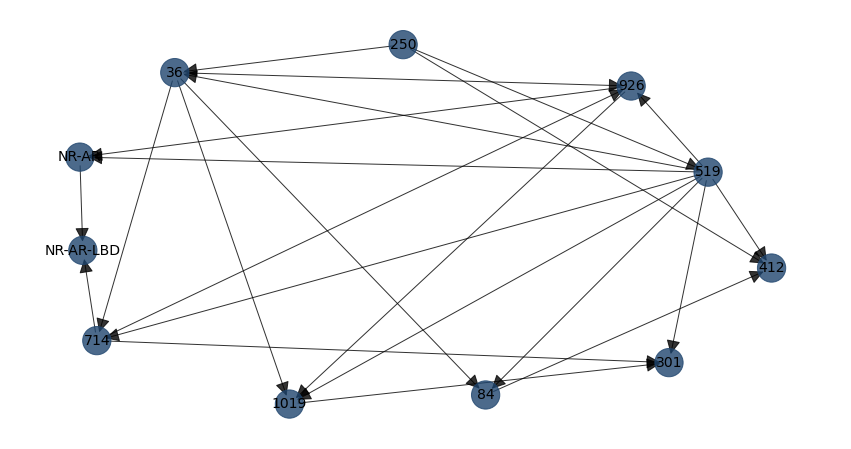

In [19]:
G = bn.plot(DAGp) #plot